# Understanding Market Structure

In [1]:
from pandas_datareader import data  
from datetime import datetime
import pandas_datareader as pdr
import pandas as pd
import mplfinance as mpf
import numpy as np
pd.options.mode.chained_assignment = None

## Nasdaq 100 Futures from mid 2018 to 2019

In [2]:
start = datetime(2018,6,1)
end = datetime(2019,12,1)
# COFFEE FUTURES
df = pdr.get_data_yahoo('NQ=F', start ,end)

In [3]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-05-31,7023.50,6958.25,6978.50,6977.00,389141.0,6977.00
2018-06-01,7090.50,6977.25,6982.50,7083.00,335020.0,7083.00
2018-06-04,7151.50,7071.75,7079.75,7148.25,247834.0,7148.25
2018-06-05,7187.50,7137.50,7147.50,7179.25,256212.0,7179.25
2018-06-06,7222.25,7142.25,7181.75,7215.00,300300.0,7215.00
...,...,...,...,...,...,...
2019-11-21,8308.00,8240.00,8261.50,8274.50,411833.0,8274.50
2019-11-22,8313.50,8233.25,8280.25,8280.50,344497.0,8280.50
2019-11-25,8379.25,8296.50,8303.25,8376.50,259485.0,8376.50


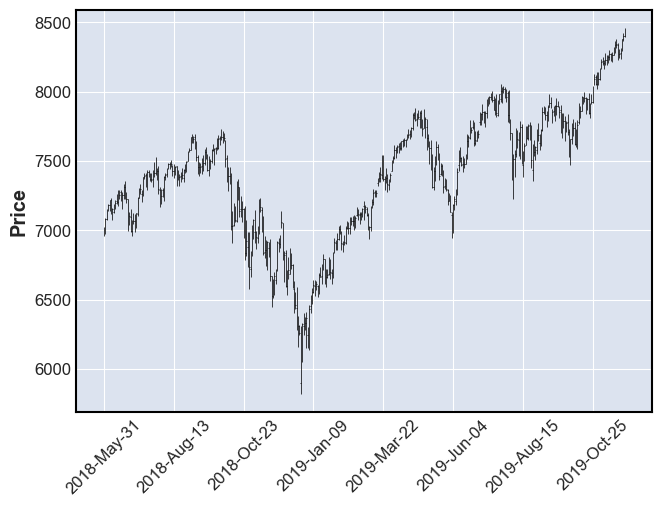

In [4]:
mpf.plot(df)

## Remove inside days & outside days

In [5]:
clean_df = df.copy()
while True:
    clean_df['prev_low'] = clean_df['Low'].shift(1)
    clean_df['next_low'] = clean_df['Low'].shift(-1)
    clean_df['prev_high'] = clean_df['High'].shift(1)
    clean_df['next_high'] = clean_df['High'].shift(-1)
    # remove inside day
    inside_day = clean_df[(clean_df['prev_high'] >= clean_df['High']) & (clean_df['prev_low'] <= clean_df['Low'])].index
    clean_df = clean_df.loc[~clean_df.index.isin(inside_day[:1])]
    if len(inside_day) > 0:
        continue
    # remove outside day
    outside_day = clean_df[(clean_df['prev_high'] <= clean_df['High']) & (clean_df['prev_low'] >= clean_df['Low'])].index
    clean_df = clean_df.loc[~clean_df.index.isin(outside_day[:1])]
    if len(outside_day) > 0:
        continue
    break

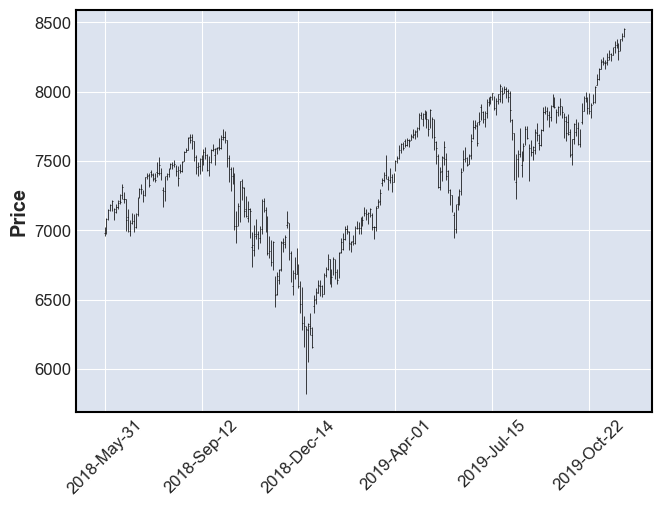

In [6]:
mpf.plot(clean_df)

## Find short term high, short term low points

In [7]:
df['short_term_high'] = np.NaN
df['short_term_low'] = np.NaN
df.loc[clean_df[(clean_df['High'] > clean_df['prev_high']) & (clean_df['High'] > clean_df['next_high'])].index, 'short_term_high'] = clean_df['High']
df.loc[clean_df[(clean_df['Low'] < clean_df['prev_low']) & (clean_df['Low'] < clean_df['next_low'])].index, 'short_term_low'] = clean_df['Low']

In [8]:
apds = [
    mpf.make_addplot(df['short_term_high'], color='green', marker='o', scatter=True),
    mpf.make_addplot(df['short_term_low'], color='red', marker='o', scatter=True)
]

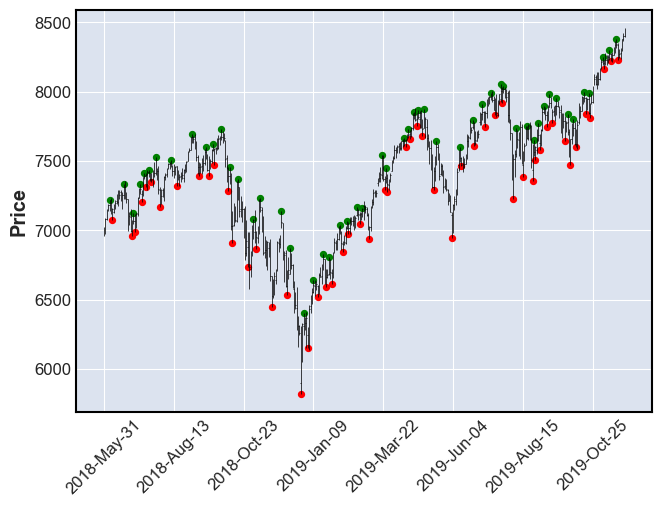

In [9]:
mpf.plot(df, addplot=apds)

## Make short term high, short term low points to graph

In [10]:
df['short_term'] = np.NaN
df['short_term'].loc[df['short_term_high'].dropna().index] = df['short_term_high']
df['short_term'].loc[df['short_term_low'].dropna().index] = df['short_term_low']
# for draw end line
df['short_term'].iloc[0] = df['Open'].iloc[0]
df['short_term'].iloc[-1] = df['Close'].iloc[-1]

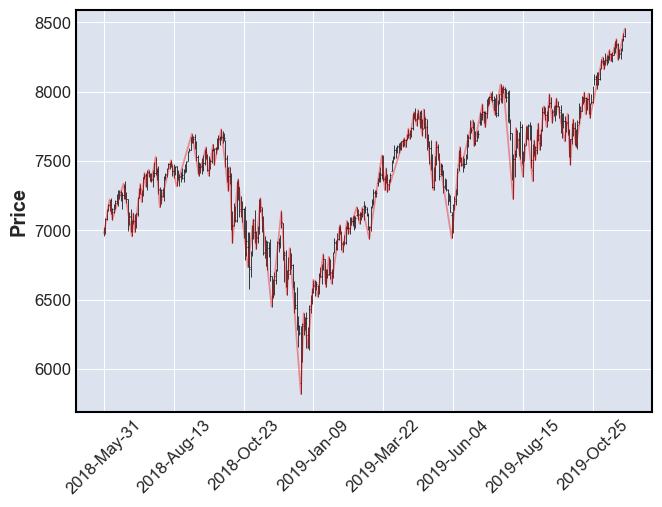

In [11]:
apds = [
    mpf.make_addplot(df['short_term'].interpolate(method='linear'), color='red', alpha=0.4)
]
mpf.plot(df, addplot=apds)

## Find intermediate term high, intermediate term low points

In [12]:
inter_df = pd.DataFrame()
inter_df = df[['short_term_high']].dropna()

In [13]:
inter_df['prev_short_term_high'] = inter_df['short_term_high'].shift(1)
inter_df['next_short_term_high'] = inter_df['short_term_high'].shift(-1)

In [14]:
df['intermediate_term_high'] = np.NaN

df.loc[
    inter_df[
      (inter_df['prev_short_term_high'] < inter_df['short_term_high']) & 
      (inter_df['next_short_term_high'] < inter_df['short_term_high'])].index, 
       'intermediate_term_high'
    ] = clean_df['High']

In [15]:
inter_df = pd.DataFrame()
inter_df['short_term_low'] = df['short_term_low'].dropna()

In [16]:
inter_df['prev_short_term_low'] = inter_df['short_term_low'].shift(1)
inter_df['next_short_term_low'] = inter_df['short_term_low'].shift(-1)

In [17]:
df['intermediate_term_low'] = np.NaN
df.loc[
    inter_df[
      (inter_df['prev_short_term_low'] > inter_df['short_term_low']) & 
      (inter_df['next_short_term_low'] > inter_df['short_term_low'])].index, 
       'intermediate_term_low'
    ] = clean_df['Low']

In [18]:
df['intermediate_term'] = np.NaN
df['intermediate_term'].loc[df['intermediate_term_high'].dropna().index] = df['intermediate_term_high']
df['intermediate_term'].loc[df['intermediate_term_low'].dropna().index] = df['intermediate_term_low']
# for draw end line
df['intermediate_term'].loc[df['short_term'].dropna().index[0]] = df['short_term'].dropna().iloc[0]
df['intermediate_term'].loc[df['short_term'].dropna().index[-1]] = df['short_term'].dropna().iloc[-1]

## Make intermediate term high, intermediate term low points to graph

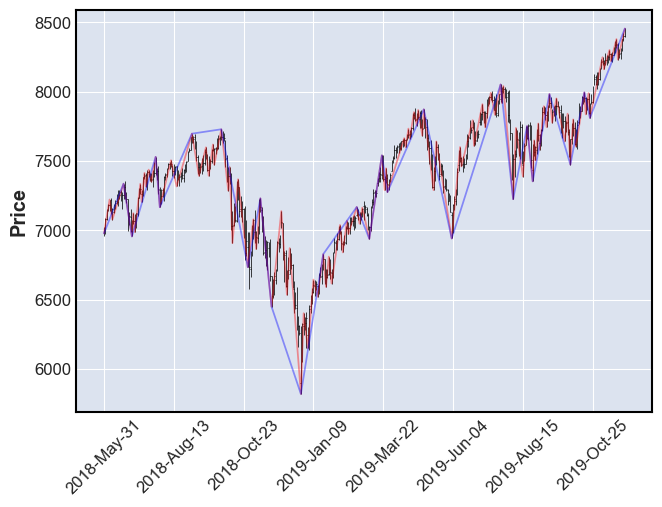

In [19]:
apds = [
    mpf.make_addplot(df['short_term'].interpolate(method='linear'), color='red', alpha=0.4),
    mpf.make_addplot(df['intermediate_term'].interpolate(method='linear'), color='blue', alpha=0.4)
]
mpf.plot(df, addplot=apds)

## Find long term high, long term low points

In [20]:
long_df = pd.DataFrame()
long_df = df[['intermediate_term_high']].dropna()

In [21]:
long_df['prev_intermediate_term_high'] = long_df['intermediate_term_high'].shift(1)
long_df['next_intermediate_term_high'] = long_df['intermediate_term_high'].shift(-1)

In [22]:
df['long_term_high'] = np.NaN

df.loc[
    long_df[
      (long_df['prev_intermediate_term_high'] < long_df['intermediate_term_high']) & 
      (long_df['next_intermediate_term_high'] < long_df['intermediate_term_high'])].index, 
       'long_term_high'
    ] = clean_df['High']

In [23]:
long_df = pd.DataFrame()
long_df['intermediate_term_low'] = df['intermediate_term_low'].dropna()

In [24]:
long_df['prev_intermediate_term_low'] = long_df['intermediate_term_low'].shift(1)
long_df['next_intermediate_term_low'] = long_df['intermediate_term_low'].shift(-1)

In [25]:
df['long_term_low'] = np.NaN
df.loc[
    long_df[
      (long_df['prev_intermediate_term_low'] > long_df['intermediate_term_low']) & 
      (long_df['next_intermediate_term_low'] > long_df['intermediate_term_low'])].index, 
       'long_term_low'
    ] = clean_df['Low']

In [26]:
df['long_term'] = np.NaN
df['long_term'].loc[df['long_term_high'].dropna().index] = df['long_term_high']
df['long_term'].loc[df['long_term_low'].dropna().index] = df['long_term_low']
# for draw end line
df['long_term'].loc[df['intermediate_term'].dropna().index[0]] = df['intermediate_term'].dropna().iloc[0]
df['long_term'].loc[df['intermediate_term'].dropna().index[-1]] = df['intermediate_term'].dropna().iloc[-1]

## Make long term high, long term low points to graph

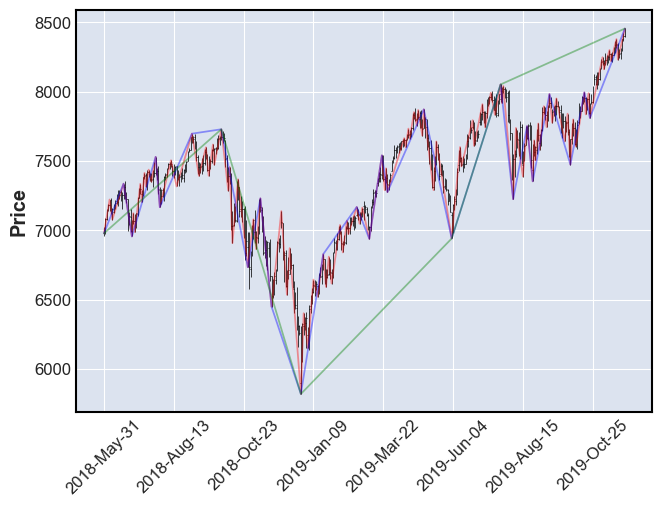

In [27]:
apds = [
    mpf.make_addplot(df['short_term'].interpolate(method='linear'), color='red', alpha=0.4),
    mpf.make_addplot(df['intermediate_term'].interpolate(method='linear'), color='blue', alpha=0.4),
    mpf.make_addplot(df['long_term'].interpolate(method='linear'), color='green', alpha=0.4)
]
mpf.plot(df, addplot=apds)